In [20]:
# notebook settings
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# external imports
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

# internal imports
from warm_start_hmpc.controller import HybridModelPredictiveController
from mld_dynamics_complementarity import CartPoleWithWalls
from warm_start_hmpc.mcais import mcais, solve_dare

In [34]:
# cart-pole system with MLD dynamics
cp = CartPoleWithWalls()

# hybrid controller
T = 20

# weight matrices
C = np.diag(np.reciprocal(cp.x_max)) * cp.h
D = np.array([[np.reciprocal(cp.fc_max)]]).T * cp.h

# LQR cost to go
P, K = solve_dare(cp.mld.A, cp.mld.B[:,:1], C.dot(C), D.dot(D))
C_T = np.linalg.cholesky(P).T
D = np.hstack((D, np.zeros((1, cp.mld.nu-1))))
objective = [C, D, C_T]

# mcais terminal set
A_cl = cp.mld.A + cp.mld.B[:,:1].dot(K)
lhs_cl = cp.mld.F + cp.mld.G[:,:1].dot(K)
terminal_set = mcais(A_cl, lhs_cl, cp.mld.h, verbose=True)

controller = HybridModelPredictiveController(
    cp.mld,
    T,
    objective,
    terminal_set
)

# initial push towards the right wall
# x0 = np.array([0., 0., 1., 0.])

Time horizon: 8. Convergence index: 0.000000. Number of facets: 64.
Maximal constraint-admissible invariant set found. Removing redundant facets ... minimal facets are 36.


## Open-loop solution

In [35]:
# solve in open loop
x0 = np.array([0., 0., 0., .3])
solution, leaves = controller.feedforward(
    x0,
    draw_label='Cart pole with walls'
)[:2]

|    Updates    |    Time (s)   |  Solved nodes |  Lower bound  |  Upper bound  |
 --------------- --------------- --------------- --------------- ---------------
 Root node       0.04            1               9.000e-04       inf             
                 3.06            81              1.088e-01       inf             
 New incumbent   4.39            124             1.227e-01       1.227e-01       
 Solution found  4.39            124             1.227e-01       1.227e-01       

Explored 124 nodes in 4.393 seconds: optimal solution found with cost 1.227e-01.


<IPython.core.display.Javascript object>


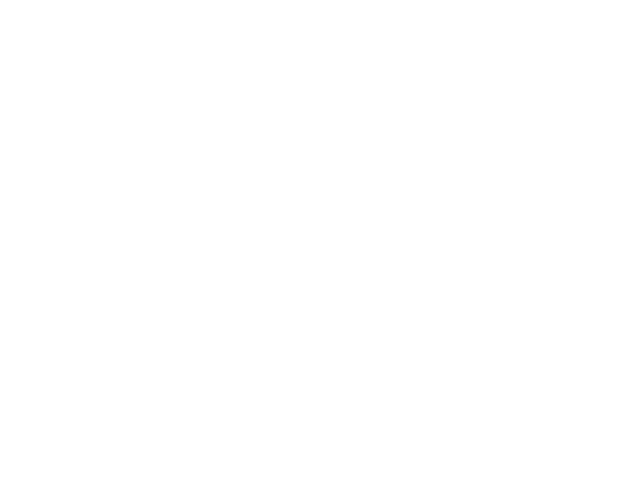

In [5]:
plt.plot(
    np.linspace(0,cp.h,T),
    [ut[0] for ut in solution.variables['uc']],
)

In [7]:
x_gurobi, obj_gurobi = controller.feedforward_gurobi(x0)[:2]

Changed value of parameter OutputFlag to 1
   Prev: 0  Min: 0  Max: 1  Default: 1
Optimize a model with 746 rows, 184 columns and 2200 nonzeros
Model has 110 quadratic objective terms
Variable types: 144 continuous, 40 integer (40 binary)
Coefficient statistics:
  Matrix range     [6e-05, 6e+01]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-03, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+00]
Presolve removed 544 rows and 58 columns
Presolve time: 0.00s
Presolved: 202 rows, 126 columns, 981 nonzeros
Presolved model has 106 quadratic objective terms
Variable types: 113 continuous, 13 integer (13 binary)

Root relaxation: objective 6.443772e-02, 285 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.06444    0    7          -    0.06444      -     -    0s
     0     0    0.06503    0    7          -    0.06503

In [ ]:
from visualizer import vis, animate
vis.jupyter_cell()

In [ ]:
animate(solution.variables['x'], cp.h)
# animate(x_gurobi, h_nom)

## Solve in closed loop

In [8]:
from visualizer import vis, visualize
vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [9]:
# set up simulation
T_sim = 3*T
x_true = [x0]
x_predicted = []
x_sim = []
u_sim = []
e_sim = []
V_sim = []
warm_start = None

for t in range(T_sim):
    print('Time step %d.'%t)#, end='\r')
    
    # solve miqp
    solution, leaves = controller.feedforward(
        cp.project_in_feasible_set(x_true[-1]),
        warm_start=warm_start,
        printing_period=20.
    )[:2]
    
    # reorganize solution
    uc0 = solution.variables['uc'][0]
    ub0 = solution.variables['ub'][0]
    u0 = np.concatenate((uc0, ub0))
    x_sim_t = cp.simulate(x_true[-1], uc0[0:1], cp.h)[0]
    x1 = x_sim_t[-1]
    e0 = x1 - cp.mld.A.dot(x_true[-1]) - cp.mld.B.dot(u0)
    print('predicted state:', solution.variables['x'][1])
    print('true state:', x1)
    print('modeling error:', e0)
    visualize(x1)
    
    # generate warm start
    warm_start = controller.construct_warm_start(
        leaves,
        cp.project_in_feasible_set(x_true[-1]),
        uc0,
        ub0,
        e0
    )
    
    # retrieve closed-loop trajectory
    x_predicted.append(solution.variables['x'][1])
    x_true.append(x1)
    x_sim.extend(x_sim_t)
    u_sim.append(uc0)
    e_sim.append(e0)
    V_sim.append(solution.objective)

Time step 0.
|    Updates    |    Time (s)   |  Solved nodes |  Lower bound  |  Upper bound  |
 --------------- --------------- --------------- --------------- ---------------
 Root node       0.04            1               4.862e-02       inf             
 New incumbent   2.49            80              6.913e-02       6.913e-02       
 Solution found  2.52            81              6.913e-02       6.913e-02       

Explored 81 nodes in 2.518 seconds: optimal solution found with cost 6.913e-02.
predicted state: [ 0.047 -0.003  0.94  -0.06 ]
true state: [ 0.04846675 -0.00153651  0.93974956 -0.06050095]
modeling error: [ 0.00146675  0.00146349 -0.00025044 -0.00050095]
Time step 1.
Loaded warm start with 39 nodes. Lower bound from warm start is 0.000.
|    Updates    |    Time (s)   |  Solved nodes |  Lower bound  |  Upper bound  |
 --------------- --------------- --------------- --------------- ---------------
 New incumbent   0.33            6               6.494e-02       6.494e-02 

 New incumbent   0.35            11              3.042e-02       3.085e-02       
 Solution found  0.41            13              3.085e-02       3.085e-02       

Explored 13 nodes in 0.413 seconds: optimal solution found with cost 3.085e-02.
predicted state: [ 0.31878995 -0.09443902  0.02630849  0.4135604 ]
true state: [ 0.31924391 -0.09247377  0.03349031  0.42653561]
modeling error: [0.00045396 0.00196524 0.00718182 0.01297521]
Time step 13.
Loaded warm start with 42 nodes. Lower bound from warm start is 0.000.
|    Updates    |    Time (s)   |  Solved nodes |  Lower bound  |  Upper bound  |
 --------------- --------------- --------------- --------------- ---------------
 New incumbent   0.31            10              2.549e-02       2.553e-02       
 Solution found  0.34            11              2.553e-02       2.553e-02       

Explored 11 nodes in 0.341 seconds: optimal solution found with cost 2.553e-02.
predicted state: [ 0.31960025 -0.07477701  0.00712688  0.3539353 ]
true

 New incumbent   0.20            6               1.123e-02       1.123e-02       
 Solution found  0.20            6               1.123e-02       1.123e-02       

Explored 6 nodes in 0.203 seconds: optimal solution found with cost 1.123e-02.
predicted state: [ 0.24306606 -0.00614327 -0.23392107 -0.00652341]
true state: [ 0.24319099 -0.00594721 -0.23393597 -0.00655334]
modeling error: [ 1.24925643e-04  1.96064070e-04 -1.48943415e-05 -2.99295270e-05]
Time step 25.
Loaded warm start with 42 nodes. Lower bound from warm start is 0.000.
|    Updates    |    Time (s)   |  Solved nodes |  Lower bound  |  Upper bound  |
 --------------- --------------- --------------- --------------- ---------------
 New incumbent   0.20            6               1.047e-02       1.047e-02       
 Solution found  0.20            6               1.047e-02       1.047e-02       

Explored 6 nodes in 0.198 seconds: optimal solution found with cost 1.047e-02.
predicted state: [ 0.23139247 -0.00652527 -0.23597028

 New incumbent   0.21            6               4.265e-03       4.265e-03       
 Solution found  0.21            6               4.265e-03       4.265e-03       

Explored 6 nodes in 0.206 seconds: optimal solution found with cost 4.265e-03.
predicted state: [ 0.1158618  -0.01236582 -0.17104549 -0.00193974]
true state: [ 0.11566686 -0.01241116 -0.17108449 -0.00201763]
modeling error: [-1.94937928e-04 -4.53382561e-05 -3.90069785e-05 -7.78884804e-05]
Time step 37.
Loaded warm start with 39 nodes. Lower bound from warm start is 0.000.
|    Updates    |    Time (s)   |  Solved nodes |  Lower bound  |  Upper bound  |
 --------------- --------------- --------------- --------------- ---------------
 New incumbent   0.21            6               3.887e-03       3.887e-03       
 Solution found  0.21            6               3.887e-03       3.887e-03       

Explored 6 nodes in 0.210 seconds: optimal solution found with cost 3.887e-03.
predicted state: [ 0.10750115 -0.0124338  -0.16331417

 New incumbent   0.19            6               1.372e-03       1.372e-03       
 Solution found  0.19            6               1.372e-03       1.372e-03       

Explored 6 nodes in 0.188 seconds: optimal solution found with cost 1.372e-03.
predicted state: [ 0.03832853 -0.0102738  -0.09273563  0.00592111]
true state: [ 0.03820134 -0.01027027 -0.09266263  0.00606709]
modeling error: [-1.27189869e-04  3.52861776e-06  7.29963320e-05  1.45979487e-04]
Time step 49.
Loaded warm start with 39 nodes. Lower bound from warm start is 0.000.
|    Updates    |    Time (s)   |  Solved nodes |  Lower bound  |  Upper bound  |
 --------------- --------------- --------------- --------------- ---------------
 New incumbent   0.18            6               1.251e-03       1.251e-03       
 Solution found  0.18            6               1.251e-03       1.251e-03       

Explored 6 nodes in 0.185 seconds: optimal solution found with cost 1.251e-03.
predicted state: [ 0.03382054 -0.00997134 -0.08761613

<IPython.core.display.Javascript object>


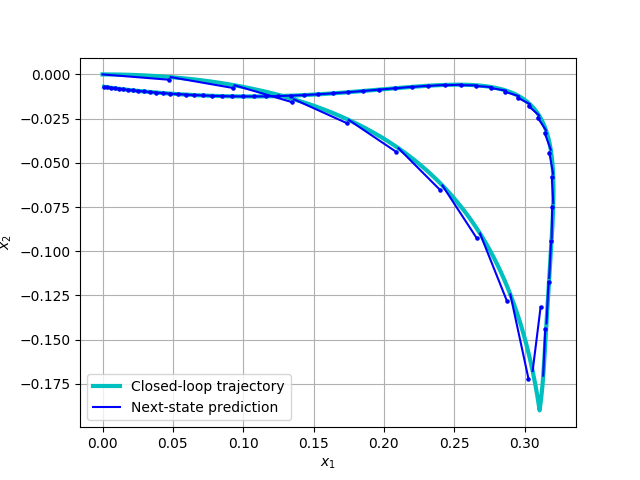

In [14]:
indices =  [0,1]
fig = plt.figure()

plt.plot(
    [xt[indices[0]] for xt in x_sim],
    [xt[indices[1]] for xt in x_sim],
    color='c',
    label='Closed-loop trajectory',
    linewidth=3
)

for t in range(T_sim):
    label = 'Next-state prediction'
    if t > 0:
        label=None
    plt.plot(
        [x_true[t][indices[0]], x_predicted[t][indices[0]]],
        [x_true[t][indices[1]], x_predicted[t][indices[1]]],
        c='b',
        label=label
    )
    plt.scatter(
        [x_predicted[t][indices[0]]],
        [x_predicted[t][indices[1]]],
        c='b',
        marker='o',
        s=5,
        zorder=3
    )
plt.xlabel(r'$x_%d$'%(indices[0]+1))
plt.ylabel(r'$x_%d$'%(indices[1]+1))
# ax.set_zlabel(r'Solved QPs')
plt.legend()
plt.grid(True)
plt.show()
# plt.savefig('error_complementarity.pdf')

## Animation

In [ ]:
from visualizer import vis, animate
vis.jupyter_cell()

In [ ]:
x0 = np.array([0, 0, 1, 0])
u0 = np.zeros(1)
dt = 5
x_sim, h = cp.simulate(x0, u0, dt)
animate(x_sim, h)

In [18]:
x_true

[array([0., 0., 1., 0.]),
 array([ 0.04846675, -0.00153651,  0.93974956, -0.06050095]),
 array([ 0.09388871, -0.00616262,  0.87798287, -0.12403654]),
 array([ 0.13615017, -0.01411013,  0.81311969, -0.19377951]),
 array([ 0.1750535 , -0.02577584,  0.74345677, -0.27317573]),
 array([ 0.21031175, -0.04173854,  0.66712331, -0.36606789]),
 array([ 0.24153986, -0.06278132,  0.58207063, -0.47678699]),
 array([ 0.26824688, -0.08991683,  0.48613584, -0.61016708]),
 array([ 0.28983489, -0.12440964,  0.3772525 , -0.77139876]),
 array([ 0.30568441, -0.16771488,  0.25665998, -0.96286846]),
 array([ 0.31321633, -0.17038878,  0.05409999,  0.63997168]),
 array([ 0.31552773, -0.14081437,  0.04067548,  0.54926986]),
 array([ 0.31747452, -0.11511704,  0.039137  ,  0.48394743]),
 array([ 0.31924391, -0.09247377,  0.03349031,  0.42653561]),
 array([ 0.32035892, -0.07279692,  0.0130558 ,  0.36493163]),
 array([ 0.32023509, -0.05618028, -0.01610496,  0.30365479]),
 array([ 0.31855454, -0.04252779, -0.0493509

In [19]:
x_sim

[array([0., 0., 1., 0.]),
 array([ 9.98800000e-04, -1.19999999e-06,  9.98800000e-01, -1.19999999e-03]),
 array([ 1.99639999e-03, -3.60002398e-06,  9.97599988e-01, -2.40002399e-03]),
 array([ 2.99279994e-03, -7.20011996e-06,  9.96399952e-01, -3.60009598e-03]),
 array([ 3.98799982e-03, -1.20003599e-05,  9.95199880e-01, -4.80023998e-03]),
 array([ 4.98199958e-03, -1.80008399e-05,  9.93999760e-01, -6.00047998e-03]),
 array([ 5.97479916e-03, -2.52016799e-05,  9.92799580e-01, -7.20083999e-03]),
 array([ 6.96639849e-03, -3.36030239e-05,  9.91599328e-01, -8.40134401e-03]),
 array([ 7.95679748e-03, -4.32050400e-05,  9.90398992e-01, -9.60201606e-03]),
 array([ 8.94599604e-03, -5.40079201e-05,  9.89198560e-01, -1.08028801e-02]),
 array([ 9.93399406e-03, -6.60118804e-05,  9.87998020e-01, -1.20039603e-02]),
 array([ 1.09207914e-02, -7.92171609e-05,  9.86797360e-01, -1.32052805e-02]),
 array([ 1.19063880e-02, -9.36240257e-05,  9.85596568e-01, -1.44068648e-02]),
 array([ 1.28907836e-02, -1.09232763e-